# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В yашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Yам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

***Признаки***

`DateCrawled` — дата скачивания анкеты из базы  
`VehicleType` — тип автомобильного кузова  
`RegistrationYear` — год регистрации автомобиля  
`Gearbox` — тип коробки передач  
`Power` — мощность (л. с.)  
`Model` — модель автомобиля  
`Kilometer` — пробег (км)  
`RegistrationMonth` — месяц регистрации автомобиля  
`FuelType` — тип топлива  
`Brand` — марка автомобиля  
`NotRepaired` — была машина в ремонте или нет  
`DateCreated` — дата создания анкеты  
`NumberOfPictures` — количество фотографий автомобиля  
`PostalCode` — почтовый индекс владельца анкеты (пользователя)  
`LastSeen` — дата последней активности пользователя  

***Целевой признак***

Price — цена (евро)

## Подготовка данных

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [3]:
try:
    df = pd.read_csv('C:\\Users\\gorbu\\OneDrive\\Документы\\DataScience\\Projects\\9 prj\\autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


### Дубликаты

In [5]:
df.duplicated().sum()

4

In [6]:
df[df.duplicated(keep=False)].sort_values(by='DateCrawled')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54


In [7]:
df = df.drop_duplicates()
df.duplicated().sum()

0

### Лишние признаки

In [8]:
df['NumberOfPictures'].unique()

array([0], dtype=int64)

Столбец NumberOfPictures нам явно не нужен. Количество фотографий у всех объектов нулевое. Удалим.
PostalCode тоже. Удалим.

In [9]:
df['DateCrawled'].min(), df['DateCrawled'].max()

('2016-03-05 14:06:22', '2016-04-07 14:36:58')

Дата скачивания анкеты из базы в диапазоне от 5 марта до 7 апреля 2016 года. Вряд-ли она влияет на стоимость, удалим.

In [10]:
df['LastSeen'].min(), df['LastSeen'].max()

('2016-03-05 14:15:08', '2016-04-07 14:58:51')

Дата последней активности пользователя в диапазоне от 5 марта до 7 апреля 2016 года. Вряд-ли она влияет на стоимость, удалим.

In [11]:
df['DateCreated'].min(), df['DateCreated'].max()

('2014-03-10 00:00:00', '2016-04-07 00:00:00')

Дата создания анкеты в теории может влять на стоимость - стоимость автомобилей ведь изменяется со временем (например, инфляция способствует росту, и, наоборот, чем дальше в будущее, тем автомобиль старше и цена ниже). Однако период тут всего два года. Удалим.

In [12]:
df = df.drop(['NumberOfPictures', 'PostalCode', 'DateCrawled', 'LastSeen', 'DateCreated'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354365 non-null  int64 
 1   VehicleType        316875 non-null  object
 2   RegistrationYear   354365 non-null  int64 
 3   Gearbox            334532 non-null  object
 4   Power              354365 non-null  int64 
 5   Model              334660 non-null  object
 6   Kilometer          354365 non-null  int64 
 7   RegistrationMonth  354365 non-null  int64 
 8   FuelType           321470 non-null  object
 9   Brand              354365 non-null  object
 10  NotRepaired        283211 non-null  object
dtypes: int64(5), object(6)
memory usage: 32.4+ MB


### Пропуски

In [13]:
missed = pd.DataFrame([df.isna().sum(), df.isna().sum() / df.shape[0] * 100]).T
missed[missed[0] !=0]

,0,1
VehicleType,37490.0,10.579487
Gearbox,19833.0,5.596772
Model,19705.0,5.560651
FuelType,32895.0,9.282802
NotRepaired,71154.0,20.079297


Пропусков много - от 5,6% до 20%.

In [14]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [15]:
df[df['Model'] == 'other']['Brand'].value_counts()

mercedes_benz    2903
citroen          1849
fiat             1789
ford             1459
hyundai          1167
peugeot          1163
opel             1135
suzuki           1058
audi             1033
mazda            1012
renault           955
chevrolet         950
toyota            844
mitsubishi        769
volkswagen        768
nissan            702
volvo             578
alfa_romeo        521
kia               499
rover             394
chrysler          381
saab              363
honda             317
skoda             264
bmw               217
jaguar            190
porsche           179
jeep              138
seat              115
daihatsu          114
lancia             99
mini               92
daewoo             91
trabant            75
smart              74
subaru             64
lada               59
dacia              22
land_rover         18
Name: Brand, dtype: int64

В other черт ногу сломит, тут все бренды... Поскольку тип кузова у одной и той же модели автомобиля вряд ли может различаться - можнго было бы заполнить пропуски кузовов по моделям авто, всем кроме "other". Проверим.

In [16]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.pivot_table(df, index=["Model", "VehicleType"]))

Kilometer        Power         Price  \
Model              VehicleType                                             
100                convertible  150000.000000   163.000000   7190.000000   
                   coupe        137500.000000   133.000000   7724.500000   
                   sedan        142392.086331   125.003597   1755.298561   
                   wagon        147431.192661   141.467890   1700.064220   
145                coupe        125000.000000    51.500000    600.000000   
                   other        100000.000000   100.000000    500.000000   
                   sedan        139615.384615   111.615385   1440.692308   
                   small        136842.105263   103.157895    798.473684   
147                coupe        141666.666667   123.000000   2161.037037   
                   other        146428.571429   120.571429   1228.571429   
                   sedan        133980.446927   117.416201   2516.128492   
                   small        138711.340206   261.896907   1811.886598   
                   suv          150000.000000   105.000000      0.000000   
                   wagon        115000.000000   158.000000   6724.500000   
156                coupe        150000.000000    93.333333   2300.000000   
                   other        150000.000000     0.000000    350.000000   
                   sedan        143222.996516   138.000000   1448.606272   
                   small        150000.000000   147.000000    675.000000   
                   wagon        146614.583333   144.045139   1699.833333   
159                sedan        126363.636364   160.454545   6544.163636   
                   wagon        130137.931034   171.117241   7419.427586   
1_reihe            bus          150000.000000    81.800000   4838.000000   
                   convertible  129166.666667   110.000000   3626.666667   
                   coupe        141666.666667    51.333333   1383.333333   
                   other          5000.000000   120.000000   5299.000000   
                   sedan        109000.000000    70.100000   2294.533333   
                   small        122366.972477    56.219266   1558.671560   
                   wagon         99150.943396    87.377358   3273.679245   
1er                convertible   88745.019920   154.350598  15488.494024   
                   coupe        116193.415638   166.588477  13263.769547   
                   other        114750.000000   146.050000   9501.650000   
                   sedan        114585.218703   143.915158   9265.101056   
                   small        107517.985612   125.784173   8964.280576   
                   wagon        109750.000000   115.950000   9301.300000   
200                convertible  150000.000000   125.000000   3000.000000   
                   sedan        140000.000000   180.600000   4105.600000   
                   wagon        150000.000000   220.000000   5000.000000   
2_reihe            bus          150000.000000    82.333333    413.333333   
                   convertible  115597.213006   113.684141   4363.936297   
                   coupe        129558.823529    92.117647   2262.235294   
                   other        129000.000000    69.700000   3059.000000   
                   sedan        116927.083333    77.984375   3161.526042   
                   small        124059.268099    75.282816   2498.891010   
                   suv           35000.000000    73.500000  11495.000000   
                   wagon        115110.701107    91.188192   3925.191882   
300c               sedan        132698.412698   230.793651   9977.333333   
                   wagon        141231.884058   233.710145  10450.086957   
3_reihe            bus           98846.153846   134.025641  10141.641026   
                   convertible  114800.796813   125.713147   5403.023904   
                   coupe        137202.380952    75.095238    919.702381   
                   other        139318.181818    94.454545   1902.090909   
        

In [17]:
df[df['Model'] == 'fabia']['VehicleType'].unique()

array(['small', 'wagon', nan, 'sedan', 'other', 'bus', 'convertible',
       'suv'], dtype=object)

Мы видим, что данные не точны. У одной модели пользователи заполняют множество вариантов типа кузова, что в реальности вряд ли возможно и является ошибкой внесения данных. Например, Шкода фабиа у нас якобы может быть: 'small', 'wagon', 'sedan', 'other', 'bus', 'convertible', 'suv'. Даже автобус.

In [18]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [19]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [20]:
df['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

С коробкой передач тоже достоверно не заполнишь пропуски - у одной и той же модели они могут быть разные. Аналогично - пропуски в названии модели - данных нет и взять их неоткуда. Тоже самое - ремонтировалось авто или нет.

In [21]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [22]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(pd.pivot_table(df, index=["Model", "FuelType"]))

Kilometer        Power         Price  \
Model              FuelType                                             
100                gasoline  144333.333333   101.400000   2209.133333   
                   lpg       150000.000000   126.625000   1850.875000   
                   petrol    143760.445682   130.208914   1796.894150   
145                gasoline  150000.000000     0.000000      0.000000   
                   petrol    132325.581395    96.441860    908.209302   
147                gasoline  145375.939850   121.669173   2564.939850   
                   lpg       148611.111111   108.666667   2005.555556   
                   petrol    132358.974359   150.456410   2244.223077   
156                gasoline  146719.576720   128.746032   1699.841270   
                   lpg       150000.000000   149.600000   1309.133333   
                   petrol    143442.622951   144.543716   1504.693989   
159                gasoline  137250.000000   163.628571   7022.150000   
                   petrol    109137.931034   175.965517   7849.465517   
1_reihe            gasoline  144102.564103    66.102564   2333.282051   
                   lpg       130000.000000    62.500000   2072.500000   
                   petrol    120913.043478    57.465217   1645.877391   
1er                gasoline  124333.737129   159.451242  10602.272562   
                   lpg       150000.000000   159.555556   7638.555556   
                   petrol    101782.065834   129.809308   9422.523837   
200                petrol    140625.000000   183.062500   4161.500000   
2_reihe            gasoline  130662.544170    87.139576   3943.810954   
                   lpg       135967.741935    90.612903   2659.870968   
                   other     150000.000000     0.000000    750.000000   
                   petrol    118879.725958    88.948236   3135.712763   
300c               gasoline  141158.536585   204.560976  10112.780488   
                   lpg       147916.666667   282.333333   9324.833333   
                   petrol    126904.761905   256.047619  10599.547619   
3_reihe            cng       150000.000000   109.000000   4800.000000   
                   electric  150000.000000    75.000000    650.000000   
                   gasoline  134886.792453   111.548428   4414.001258   
                   hybrid     70000.000000   163.000000  15600.000000   
                   lpg       137234.042553   106.319149   3054.531915   
                   petrol    127231.182796    98.577337   2925.070306   
3er                cng       116000.000000   459.800000   2170.000000   
                   electric  150000.000000   170.000000   7750.000000   
                   gasoline  141902.618658   158.660393   7841.825900   
                   lpg       146388.059701   150.779104   3975.940299   
                   other     101666.666667    97.666667   4563.333333   
                   petrol    139986.741420   140.063565   4175.051519   
4_reihe            gasoline  138138.801262   135.703470   4642.646688   
                   lpg       150000.000000   153.666667   2760.000000   
                   petrol    135752.895753   123.131274   2218.660232   
500                electric   30000.000000    36.000000  10500.000000   
                   gasoline   81078.431373    82.980392   8494.882353   
                   hybrid    125000.000000    75.000000   4500.000000   
                   lpg       125000.000000    84.750000   5450.000000   
                   other      70000.000000    18.000000   6800.000000   
                   petrol     56330.891331    72.311355   7822.816850   
5_reihe            gasoline  123117.408907   134.477733   8331.817814   
                   hybrid    150000.000000   163.000000  14900.000000   
                   lpg       144444.444444   119.777778   4854.222222   
                   petrol    106360.946746   123.485207   7803.502959   
5er                cng       150000.000000   141.000000   6450.000000   
                  

In [23]:
df[df['Model'] == 'avensis']['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'hybrid'], dtype=object)

У одной модели может быть несколько вариантов топлива. Например, Тойота авнсис у нас может заправляться: 'petrol', 'gasoline', 'lpg', 'hybrid'. Алгоритм массового заполнения непонятен, только вручную, что трудоемко.

С одной стороны пропусков много, до 20% по некоторым столбцам. Но и объектов 350 тысяч, данных для обучения много. Пропуски у нас в категориальных признаках - средним или медианой не заполнишь. Если пропуски удалить - то модели будут точнее предсказывать, чем если мы заполним заведомо недостоверными данными. Удалим пропуски.

In [24]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 245810 entries, 3 to 354367
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              245810 non-null  int64 
 1   VehicleType        245810 non-null  object
 2   RegistrationYear   245810 non-null  int64 
 3   Gearbox            245810 non-null  object
 4   Power              245810 non-null  int64 
 5   Model              245810 non-null  object
 6   Kilometer          245810 non-null  int64 
 7   RegistrationMonth  245810 non-null  int64 
 8   FuelType           245810 non-null  object
 9   Brand              245810 non-null  object
 10  NotRepaired        245810 non-null  object
dtypes: int64(5), object(6)
memory usage: 22.5+ MB


In [25]:
missed = pd.DataFrame([df.isna().sum(), df.isna().sum() / df.shape[0] * 100]).T
missed[missed[0] !=0]

,0,1


Жестко, но логично.

### Аномалии

In [26]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,245810.0,5125.391485,4717.970659,0.0,1499.0,3500.0,7500.0,20000.0
RegistrationYear,245810.0,2002.918726,6.163809,1910.0,1999.0,2003.0,2007.0,2018.0
Power,245810.0,119.970294,139.388010,0.0,75.0,110.0,150.0,20000.0
Kilometer,245810.0,127296.977340,37078.433644,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,245810.0,6.179716,3.479531,0.0,3.0,6.0,9.0,12.0


#### Цена

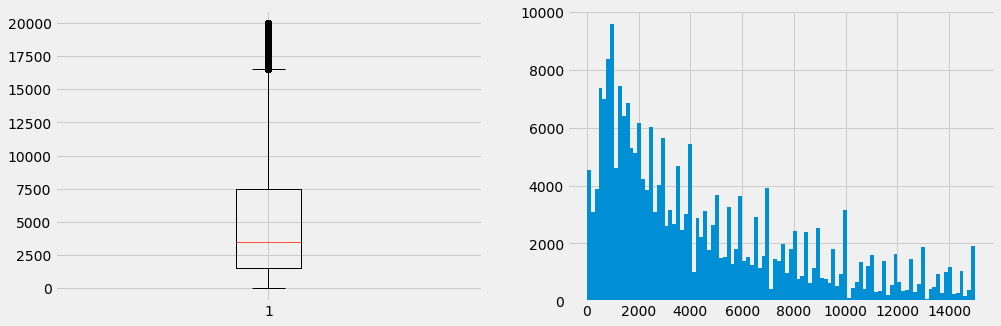

count    245810.000000
mean       5125.391485
std        4717.970659
min           0.000000
25%        1499.000000
50%        3500.000000
75%        7500.000000
max       20000.000000
Name: Price, dtype: float64

In [27]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].boxplot(df['Price'])
axs[1].hist(df["Price"], range= (0,15000), bins=100, rwidth=1)

plt.show()
df['Price'].describe()

<AxesSubplot:>

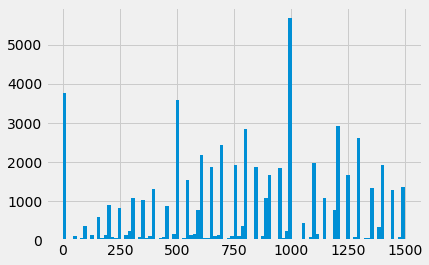

In [28]:
df["Price"].hist(range= (0,1499), bins=100, rwidth=1)

<AxesSubplot:>

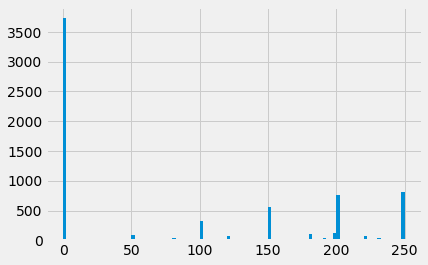

In [29]:
df["Price"].hist(range= (0,250), bins=100, rwidth=1)

In [30]:
pd.Series(df['Price'].sort_values(ascending=True).unique()).head(40)

0       0
1       1
2       2
3       3
4       5
5       9
6      10
7      11
8      13
9      15
10     16
11     20
12     25
13     29
14     30
15     35
16     39
17     40
18     45
19     47
20     50
21     55
22     59
23     60
24     65
25     66
26     70
27     75
28     79
29     80
30     85
31     89
32     90
33     95
34     98
35     99
36    100
37    101
38    105
39    110
dtype: int64

In [31]:
df[(df['Price'] >= 0) & (df['Price'] <= 100)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
7,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no
89,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no
152,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes
268,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no
579,0,sedan,1996,manual,170,5er,150000,0,petrol,bmw,no
...,...,...,...,...,...,...,...,...,...,...,...
353943,0,sedan,1999,manual,150,golf,125000,10,petrol,volkswagen,no
353995,0,sedan,1991,manual,133,100,150000,6,petrol,audi,no
354124,0,small,2004,manual,200,golf,150000,0,petrol,volkswagen,no
354277,0,small,1999,manual,37,arosa,150000,7,petrol,seat,yes


Есть автомобили бесплатно, за 1 евро, 2 евро и так далее. Бесплатно - это явно ошибка в данных, слишком низкая цена - наверняка тоже. Посмотрим межквартильный размах, и внутренни и внешние границы выбросов (1,5 и 3 межквартильных размаха).

In [32]:
q1 = df['Price'].quantile(0.25)
q3 = df['Price'].quantile(0.75)
iqr = q3 - q1  #межквартильный размах
l_inner = q1 - 1.5 * iqr
h_inner = q3 + 1.5 * iqr
l_outer = q1 - 3 * iqr
h_outer = q3 + 3 * iqr
iqr, l_outer, l_inner, q1, q3, h_inner, h_outer

(6001.0, -16504.0, -7502.5, 1499.0, 7500.0, 16501.5, 25503.0)

In [33]:
df[df['Price'] >= 16500].count()

Price                9156
VehicleType          9156
RegistrationYear     9156
Gearbox              9156
Power                9156
Model                9156
Kilometer            9156
RegistrationMonth    9156
FuelType             9156
Brand                9156
NotRepaired          9156
dtype: int64

Обрезать по внутренней или внешней границе смысла, наверное, нет. Внешние границы широкие. Поскольку цена - целевой признак, обрежем только нижние аномалии - до 100 евро. Видимо, это в основном автохлам.

In [34]:
df = df.query('Price > 100')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241465 entries, 3 to 354367
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              241465 non-null  int64 
 1   VehicleType        241465 non-null  object
 2   RegistrationYear   241465 non-null  int64 
 3   Gearbox            241465 non-null  object
 4   Power              241465 non-null  int64 
 5   Model              241465 non-null  object
 6   Kilometer          241465 non-null  int64 
 7   RegistrationMonth  241465 non-null  int64 
 8   FuelType           241465 non-null  object
 9   Brand              241465 non-null  object
 10  NotRepaired        241465 non-null  object
dtypes: int64(5), object(6)
memory usage: 22.1+ MB


#### Год регистрации

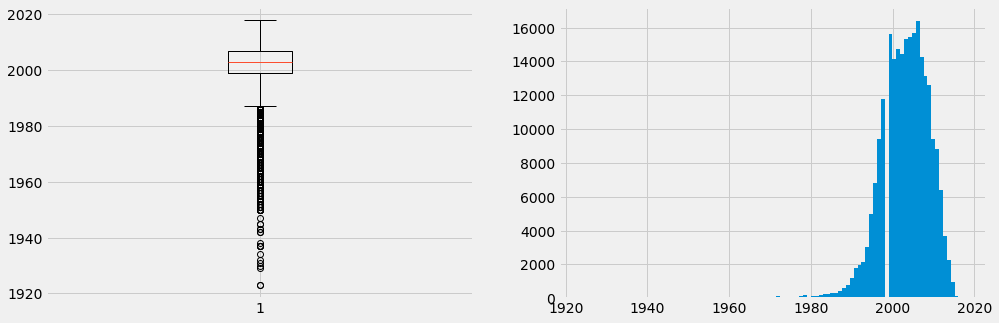

count    241465.000000
mean       2002.994633
std           6.127028
min        1923.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2018.000000
Name: RegistrationYear, dtype: float64

In [35]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].boxplot(df['RegistrationYear'])
axs[1].hist(df["RegistrationYear"], bins=100, rwidth=1)

plt.show()
df['RegistrationYear'].describe()

<AxesSubplot:>

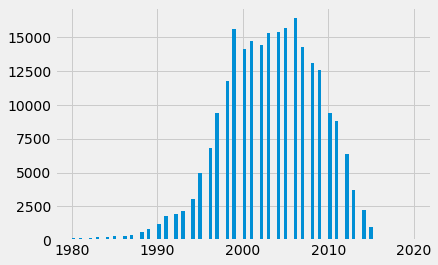

In [36]:
df["RegistrationYear"].hist(range= (1980,2020), bins=100, rwidth=1)

In [37]:
df['RegistrationYear'].sort_values(ascending=True).unique()

array([1923, 1929, 1930, 1931, 1932, 1934, 1937, 1938, 1942, 1943, 1945,
       1947, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959,
       1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970,
       1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981,
       1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992,
       1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018], dtype=int64)

Есть разнообразнейшие ошибки: ниже 1910 года сто процентов и, аналогично, выше 2016 - так как в анкетах самые поздние даты были в 2016 году. Посмотрим сколько таких? Нижнюю границу примем в 1950.

In [38]:
df.query('1950 > RegistrationYear ').count()

Price                19
VehicleType          19
RegistrationYear     19
Gearbox              19
Power                19
Model                19
Kilometer            19
RegistrationMonth    19
FuelType             19
Brand                19
NotRepaired          19
dtype: int64

In [39]:
df.query('1950 > RegistrationYear')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1928,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no
33638,5400,small,1937,manual,0,other,20000,3,petrol,opel,no
34055,2900,small,1937,manual,34,other,40000,7,petrol,ford,yes
68185,19900,convertible,1932,manual,18,other,5000,2,petrol,bmw,no
74942,12000,suv,1945,manual,45,other,50000,2,petrol,volkswagen,no
88033,6999,suv,1942,manual,72,other,150000,2,gasoline,jeep,no
117371,8750,convertible,1923,manual,11,c3,5000,0,petrol,citroen,no
144046,15999,suv,1943,manual,54,other,50000,7,gasoline,jeep,no
146207,12999,small,1938,manual,40,2_reihe,70000,1,petrol,peugeot,no
157965,3350,other,1934,manual,0,other,5000,0,petrol,opel,yes


In [40]:
df.query('2016 < RegistrationYear').count()

Price                10
VehicleType          10
RegistrationYear     10
Gearbox              10
Power                10
Model                10
Kilometer            10
RegistrationMonth    10
FuelType             10
Brand                10
NotRepaired          10
dtype: int64

In [41]:
df.query('2016 < RegistrationYear')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
43511,9999,wagon,2017,manual,102,a3,90000,8,petrol,audi,no
54271,2350,sedan,2017,auto,170,5er,150000,6,petrol,bmw,no
82608,4750,sedan,2018,manual,0,polo,150000,12,gasoline,volkswagen,no
97671,2350,sedan,2017,auto,170,5er,150000,6,petrol,bmw,no
130706,11950,bus,2017,manual,130,transporter,150000,7,gasoline,volkswagen,no
159345,1900,small,2018,manual,75,polo,150000,12,petrol,volkswagen,no
232344,800,small,2017,manual,16,a3,30000,0,petrol,audi,yes
237125,1650,coupe,2018,manual,140,3er,150000,5,petrol,bmw,no
246804,6000,small,2017,manual,155,punto,150000,5,petrol,fiat,no
334726,3150,wagon,2017,manual,135,golf,20000,11,petrol,volkswagen,no


Аномалий немного, удалим по выбранным границам.

In [42]:
df = df.query('1950 < RegistrationYear < 2017')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241430 entries, 3 to 354367
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              241430 non-null  int64 
 1   VehicleType        241430 non-null  object
 2   RegistrationYear   241430 non-null  int64 
 3   Gearbox            241430 non-null  object
 4   Power              241430 non-null  int64 
 5   Model              241430 non-null  object
 6   Kilometer          241430 non-null  int64 
 7   RegistrationMonth  241430 non-null  int64 
 8   FuelType           241430 non-null  object
 9   Brand              241430 non-null  object
 10  NotRepaired        241430 non-null  object
dtypes: int64(5), object(6)
memory usage: 22.1+ MB


#### Мощность

In [43]:
df['Power'].sort_values(ascending=True).unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

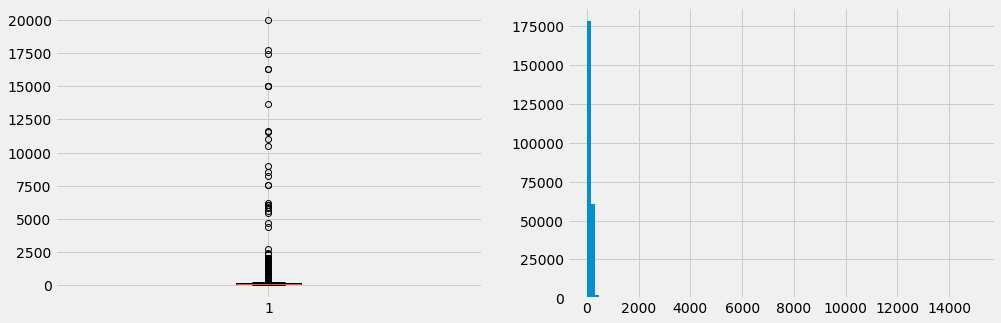

count    241430.000000
mean        120.277492
std         136.947437
min           0.000000
25%          75.000000
50%         111.000000
75%         150.000000
max       20000.000000
Name: Power, dtype: float64

In [44]:
plt.style.use("fivethirtyeight")
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].boxplot(df['Power'])
axs[1].hist(df["Power"], range= (0,15000), bins=100, rwidth=1)

plt.show()
df['Power'].describe()

<AxesSubplot:>

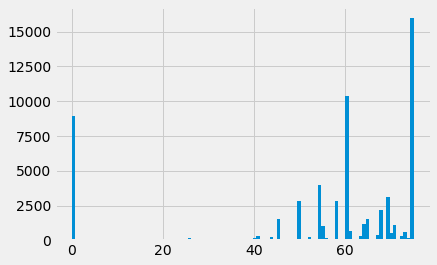

In [45]:
df["Power"].hist(range= (0,75), bins=100, rwidth=1)

Нули - по существу это пропуски в данных. Заполним нули в мощности медианным значением по названию модели.

In [46]:
for i in (df['Model'].unique()):
    df.loc[((df['Model'] == i) & (df['Power'].isna())), 'Power'] = df.loc[(df['Model'] == i), 'Power'].median()

Посмотрим на выбросы внимательнее.

<AxesSubplot:>

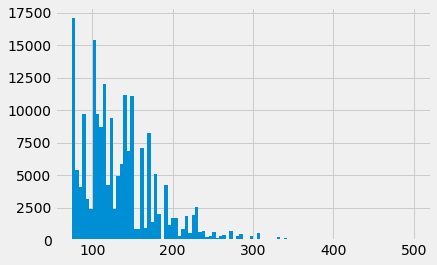

In [47]:
df["Power"].hist(range= (75,500), bins=100, rwidth=1)

<AxesSubplot:>

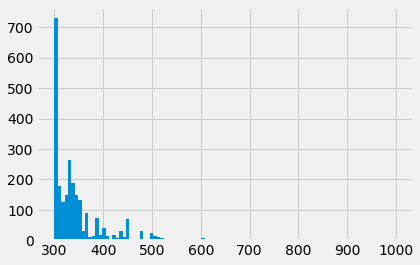

In [48]:
df["Power"].hist(range= (300,1000), bins=100, rwidth=1)

In [49]:
df[(df['Power'] >= 1) & (df['Power'] <= 40)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
844,500,small,1998,manual,39.0,other,80000,3,petrol,fiat,no
1235,4450,small,1971,manual,23.0,500,70000,5,petrol,fiat,no
1920,1999,small,2001,auto,33.0,fortwo,125000,12,petrol,smart,no
4501,3499,small,1985,manual,39.0,polo,40000,7,petrol,volkswagen,no
5676,650,sedan,1985,manual,26.0,601,30000,1,petrol,trabant,yes
...,...,...,...,...,...,...,...,...,...,...,...
353501,11300,sedan,1988,manual,29.0,other,150000,3,petrol,citroen,no
353514,500,small,2000,manual,39.0,micra,125000,7,petrol,nissan,yes
353786,4200,small,1992,manual,34.0,other,125000,1,petrol,renault,no
354316,3300,coupe,1957,manual,40.0,other,100000,11,petrol,trabant,no


In [50]:
df[df['Power'] >= 365]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1816,3200,small,2004,manual,1398.0,corolla,5000,6,petrol,toyota,no
2781,19500,suv,2004,auto,450.0,cayenne,125000,12,petrol,porsche,no
2901,12900,sedan,2006,auto,387.0,s_klasse,150000,7,petrol,mercedes_benz,no
3245,15500,sedan,2006,auto,387.0,s_klasse,150000,2,petrol,mercedes_benz,no
3289,16899,wagon,2003,auto,476.0,e_klasse,150000,9,petrol,mercedes_benz,no
...,...,...,...,...,...,...,...,...,...,...,...
352248,15900,sedan,2001,manual,400.0,m_reihe,150000,8,petrol,bmw,no
352295,18500,wagon,2007,auto,386.0,e_klasse,150000,2,petrol,mercedes_benz,no
352322,15999,wagon,2007,auto,435.0,other,150000,2,petrol,audi,no
353388,9690,wagon,2005,auto,367.0,5er,150000,9,petrol,bmw,no


In [51]:
q1 = df['Power'].quantile(0.25)
q3 = df['Power'].quantile(0.75)
iqr = q3 - q1  #межквартильный размах
l_inner = q1 - 1.5 * iqr
h_inner = q3 + 1.5 * iqr
l_outer = q1 - 3 * iqr
h_outer = q3 + 3 * iqr
iqr, l_outer, l_inner, q1, q3, h_inner, h_outer

(75.0, -150.0, -37.5, 75.0, 150.0, 262.5, 375.0)

Обрежем снизу все, что меньше 40, сверху - по внешней границе (3 квартиль + 3 межквартильных размаха).

In [52]:
df = df.query('40 < Power < 375')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231132 entries, 3 to 354367
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              231132 non-null  int64  
 1   VehicleType        231132 non-null  object 
 2   RegistrationYear   231132 non-null  int64  
 3   Gearbox            231132 non-null  object 
 4   Power              231132 non-null  float64
 5   Model              231132 non-null  object 
 6   Kilometer          231132 non-null  int64  
 7   RegistrationMonth  231132 non-null  int64  
 8   FuelType           231132 non-null  object 
 9   Brand              231132 non-null  object 
 10  NotRepaired        231132 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 21.2+ MB


#### Пробег

In [53]:
df['Kilometer'].sort_values(ascending=True).unique()

array([  5000,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 125000, 150000], dtype=int64)

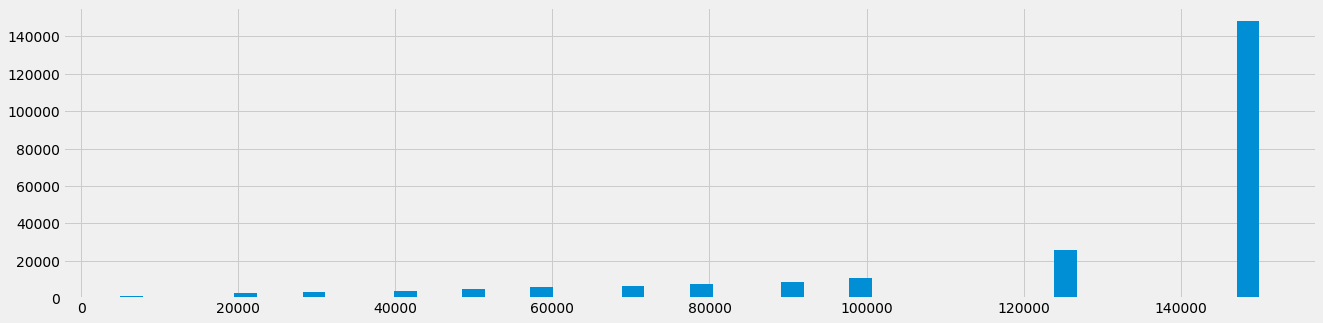

In [54]:
plt.style.use("fivethirtyeight")
ax = df['Kilometer'].hist(bins=50, figsize=(20, 5))

Аномалии не видны.

## Обучение моделей

### Cтандартизация, разделение выборок

Сделаем два набора - для решающего дерева с кодированием и для CatBoost - без него.

In [55]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.shape

(231132, 306)

In [56]:
#без кодирования
target = df['Price']
features = df.drop(['Price'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
print(target_train.shape)
print(target_valid.shape)
print(target_test.shape)

(138679, 10)
(46226, 10)
(46227, 10)
(138679,)
(46226,)
(46227,)


In [57]:
#c кодированием
target_ohe = df_ohe['Price']
features_ohe = df_ohe.drop(['Price'], axis=1)
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.4, random_state=12345)
features_valid_ohe, features_test_ohe, target_valid_ohe, target_test_ohe = train_test_split(
    features_valid_ohe, target_valid_ohe, test_size=0.5, random_state=12345)

print(features_train_ohe.shape)
print(features_valid_ohe.shape)
print(features_test_ohe.shape)
print(target_train_ohe.shape)
print(target_valid_ohe.shape)
print(target_test_ohe.shape)

(138679, 305)
(46226, 305)
(46227, 305)
(138679,)
(46226,)
(46227,)


In [58]:
numeric = df.drop(['Price'], axis=1).select_dtypes(exclude="object").columns
numeric

Index(['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth'], dtype='object')

In [59]:
#без кодирования
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
68718,suv,0.474961,manual,0.098639,ducato,0.621801,-0.644115,gasoline,fiat,no
87867,sedan,-0.877598,manual,-0.672187,3_reihe,0.621801,-1.513510,petrol,mazda,no
98497,sedan,-1.046667,manual,0.908007,5er,0.621801,1.094677,petrol,bmw,no
119187,small,0.813100,manual,-0.826353,corsa,-1.000834,-0.354316,petrol,opel,no
349586,wagon,-0.708528,manual,0.522594,a6,0.621801,0.225281,gasoline,audi,no


In [60]:
#c кодированием
pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_valid_ohe[numeric] = scaler.transform(features_valid_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])
features_train_ohe.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
68718,0.474961,0.098639,0.621801,-0.644115,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
87867,-0.877598,-0.672187,0.621801,-1.513510,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
98497,-1.046667,0.908007,0.621801,1.094677,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
119187,0.813100,-0.826353,-1.000834,-0.354316,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
349586,-0.708528,0.522594,0.621801,0.225281,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Решающее дерево

In [61]:
%%time
best_model = None
best_result = 100000
best_depth = 0
for depth in range(1, 15):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train_ohe, target_train_ohe)
    predicted_valid_ohe = model.predict(features_valid_ohe)
    result = mean_squared_error(target_valid_ohe, predicted_valid_ohe, squared=False)
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth
        
print("RMSE лучшей модели:", best_result)
print("Глубина лучшей модели:", best_depth)

RMSE лучшей модели: 1852.0932754539804
Глубина лучшей модели: 14
CPU times: total: 27.4 s
Wall time: 27.4 s


### CatBoost

In [62]:
%%time
cat_features = ['VehicleType', 'FuelType', 'Gearbox',
                'Model', 'Brand', 'NotRepaired']

best_model = None
best_result = 100000
best_depth = 0
best_iteration = 0
for iteration in range(10, 50, 10):
    for depth in range(1, 15):
        model = CatBoostRegressor(loss_function="RMSE", iterations=iteration, learning_rate=0.5, depth=depth)
        model.fit(features_train, target_train, cat_features=cat_features, verbose=10)
        predicted_valid = model.predict(features_valid)
        result = mean_squared_error(target_valid, predicted_valid, squared=False)
        if result < best_result:
            best_model = model
            best_result = result
            best_iteration = iteration
            best_depth = depth
        
print("RMSE лучшей модели:", best_result)
print("Количество итераций лучшей модели:", best_iteration)
print("Глубина лучшей модели:", best_depth)

0:	learn: 3929.8846404	total: 171ms	remaining: 1.54s
9:	learn: 2590.5011028	total: 292ms	remaining: 0us
0:	learn: 3650.8926581	total: 18.3ms	remaining: 165ms
9:	learn: 2273.1493552	total: 219ms	remaining: 0us
0:	learn: 3470.4008448	total: 23ms	remaining: 207ms
9:	learn: 2082.3776865	total: 252ms	remaining: 0us
0:	learn: 3392.9632729	total: 57.8ms	remaining: 520ms
9:	learn: 1991.5359883	total: 342ms	remaining: 0us
0:	learn: 3333.1540293	total: 44.6ms	remaining: 402ms
9:	learn: 1908.2644065	total: 403ms	remaining: 0us
0:	learn: 3277.5140041	total: 71.5ms	remaining: 644ms
9:	learn: 1864.2810776	total: 505ms	remaining: 0us
0:	learn: 3231.7777705	total: 112ms	remaining: 1.01s
9:	learn: 1821.6267940	total: 576ms	remaining: 0us
0:	learn: 3231.8650485	total: 62ms	remaining: 558ms
9:	learn: 1791.0801002	total: 628ms	remaining: 0us
0:	learn: 3195.7463865	total: 85.8ms	remaining: 772ms
9:	learn: 1744.2160749	total: 667ms	remaining: 0us
0:	learn: 3167.2817330	total: 73.7ms	remaining: 664ms
9:	lear

### LightGBM

In [63]:
%%time

best_model = None
best_result = 100000
best_depth = 0
best_iteration = 0
for iteration in range(10, 50, 10):
    for depth in range(1, 15):
        model = LGBMRegressor(max_depth=depth, n_estimators=iteration, learning_rate=0.5)
        model.fit(features_train_ohe, target_train_ohe)
        predicted_valid = model.predict(features_valid_ohe)
        result = mean_squared_error(target_valid_ohe, predicted_valid_ohe, squared=False)
        if result < best_result:
            best_model = model
            best_result = result
            best_iteration = iteration
            best_depth = depth
        
print("RMSE лучшей модели:", best_result)
print("Количество итераций лучшей модели:", best_iteration)
print("Глубина лучшей модели:", best_depth)

RMSE лучшей модели: 1852.0932754539804
Количество итераций лучшей модели: 10
Глубина лучшей модели: 1
CPU times: total: 5min 9s
Wall time: 43.9 s


## Анализ моделей

Решающее дерево и LightGBM показали абсолютно одинаковые значения метрики RMSE - 1852, против 1580 CatBoost.Посмотрим за какое время справляются лучшие модели.

### Решающее дерево

In [64]:
model = DecisionTreeRegressor(random_state=12345, max_depth=14)

In [65]:
%%time
model.fit(features_train_ohe, target_train_ohe)

CPU times: total: 3.52 s
Wall time: 3.15 s


DecisionTreeRegressor(max_depth=14, random_state=12345)

In [66]:
%%time
predicted_valid_ohe = model.predict(features_valid_ohe)

CPU times: total: 62.5 ms
Wall time: 69 ms


In [67]:
result = mean_squared_error(target_valid_ohe, predicted_valid_ohe, squared=False)

print("RMSE лучшей модели:", result)

RMSE лучшей модели: 1852.0932754539804


### CatBoost

In [68]:
cat_features = ['VehicleType', 'FuelType', 'Gearbox',
                'Model', 'Brand', 'NotRepaired']
model = CatBoostRegressor(loss_function="RMSE", iterations=40, learning_rate=0.5, depth=13)

In [69]:
%%time
model.fit(features_train, target_train, cat_features=cat_features, verbose=10)

0:	learn: 3126.2815797	total: 182ms	remaining: 7.11s
10:	learn: 1584.8085065	total: 1.97s	remaining: 5.19s
20:	learn: 1485.0625778	total: 3.77s	remaining: 3.41s
30:	learn: 1396.8486633	total: 5.55s	remaining: 1.61s
39:	learn: 1349.1747613	total: 7.17s	remaining: 0us
CPU times: total: 23.9 s
Wall time: 7.49 s


In [70]:
%%time
predicted_valid = model.predict(features_valid)

CPU times: total: 250 ms
Wall time: 79 ms


In [71]:
result = mean_squared_error(target_valid, predicted_valid, squared=False)

print("RMSE лучшей модели:", result)

RMSE лучшей модели: 1580.1559288716073


### LightGBM

In [72]:
model = LGBMRegressor(max_depth=1, n_estimators=10, learning_rate=0.5)

In [77]:
%%time
model.fit(features_train_ohe, target_train_ohe)

CPU times: total: 2.48 s
Wall time: 572 ms


LGBMRegressor(learning_rate=0.5, max_depth=1, n_estimators=10)

In [74]:
%%time
predicted_valid = model.predict(features_valid_ohe)

CPU times: total: 1.19 s
Wall time: 111 ms


In [75]:
result = mean_squared_error(target_valid_ohe, predicted_valid_ohe, squared=False)
        
print("RMSE лучшей модели:", best_result)

RMSE лучшей модели: 1852.0932754539804


### Выбор модели

**Решающее дерево:**
1. RMSE - 1852 евро.
2. Время обучения - 3.52 s.
3. Время предсказания - 62.5 ms

**CatBoost:**
1. RMSE - 1580 евро.
2. Время обучения - 23.9 s.
3. Время предсказания - 250 ms

**LightGBM:**
1. RMSE - 1852 евро.
2. Время обучения - 2.48 s.
3. Время предсказания - 1.19 s

Для заказчика важны в порядке убывания - точность предсказания, время предсказания и время обучения.
Поскольку медианное значение цены 3500 евро и даже лучшая метрика составляет 1580 евро (худшая - 1852 евро), то выбрать стоит модель по меньшей метрике - каждый евро на счету, средняя ошибка довольно большая.
Итак, выбираем CatBoost: 1 место по точности, 2 место по скорости предсказания и (увы) 3 место по времени обучения (причем с большим отрывом).

### Проверка на тестовой выборке

In [78]:
cat_features = ['VehicleType', 'FuelType', 'Gearbox',
                'Model', 'Brand', 'NotRepaired']
model = CatBoostRegressor(loss_function="RMSE", iterations=40, learning_rate=0.5, depth=13)

In [79]:
%%time
model.fit(features_train, target_train, cat_features=cat_features, verbose=10)

0:	learn: 3126.2815797	total: 181ms	remaining: 7.05s
10:	learn: 1584.8085065	total: 1.98s	remaining: 5.22s
20:	learn: 1485.0625778	total: 3.76s	remaining: 3.4s
30:	learn: 1396.8486633	total: 5.56s	remaining: 1.61s
39:	learn: 1349.1747613	total: 7.16s	remaining: 0us
CPU times: total: 24.6 s
Wall time: 7.49 s


In [82]:
%%time
predicted_test = model.predict(features_test)

CPU times: total: 172 ms
Wall time: 70.2 ms


In [83]:
result = mean_squared_error(target_test, predicted_test, squared=False)

print("RMSE лучшей модели:", result)

RMSE лучшей модели: 1576.4330541303361


На тестовой выборке почти идентичный результат. Метрика 1576,4, время предсказания - 172 мс. 